In [6]:
import sys
sys.path.append(r'../')
import numpy as np
from scipy import signal
import mat73
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.animation as animation
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
%reload_ext autoreload
%autoreload 2
from functions import *

In [7]:
data = Database()
X = data.neuron_traces.T
B = data.states

AssertionError: NoStim_Data.mat does not exist

## Preprocessing the data

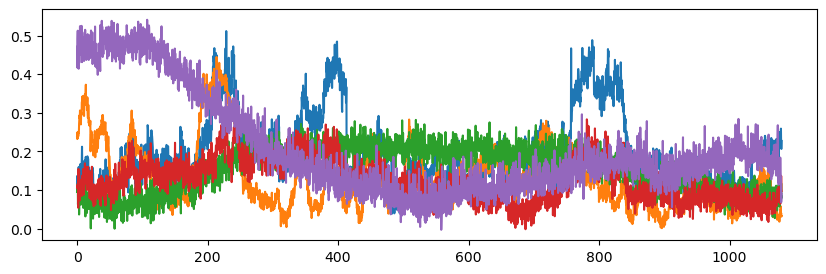

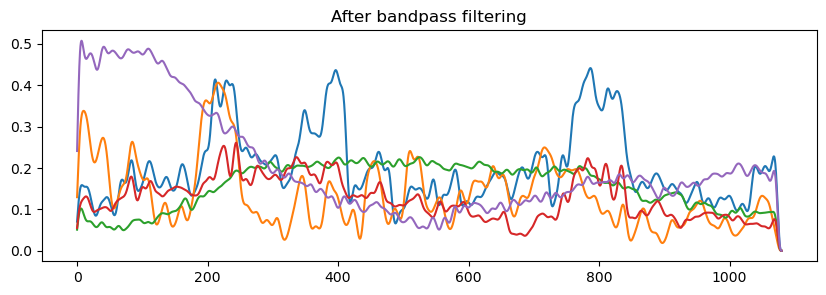

In [4]:
time = 1/data.fps*np.arange(0,X.shape[0])
filtered = bandpass(X.T, f_l=1e-10, f_h=0.05, sampling_freq=data.fps).T

nn = np.arange(80,85)
plt.figure(figsize = [10,3])
plt.plot(time, X[:,nn])
plt.figure(figsize = [10,3])
plt.plot(time, filtered[:,nn])
plt.title('After bandpass filtering')
plt.show()

X = filtered

### Preparing the data  

In [24]:
# Preparing the data (Method new)
win = 15
win += 1
gap = 1
X_win = np.zeros((X.shape[0]-win-gap, win, X.shape[1]))

for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]

Xwin0, Xwin1 = X_win[:,:-1,:], X_win[:,1:,:]
B_1 = B[1:]
X_paired = np.array([Xwin0, Xwin1])
X_paired = np.transpose(X_paired, axes=(1,0,2,3))

# Train test split 
kf = KFold(n_splits=7)
for i, (train_index, test_index) in enumerate(kf.split(X_win)):
    if i==4: 
        # Train test split based on a fold
        X_train, X_test = X_paired[train_index], X_paired[test_index]
        B_train_1, B_test_1 = B_1[train_index], B_1[test_index]        

In [32]:
X_train = X_train.reshape(X_train.shape[0],2,1,-1)
X_test = X_test.reshape(X_test.shape[0],2,1,-1)
X_test.shape

(446, 2, 1, 1635)

### Calculating participation ratio


Participation ratio:  3.627


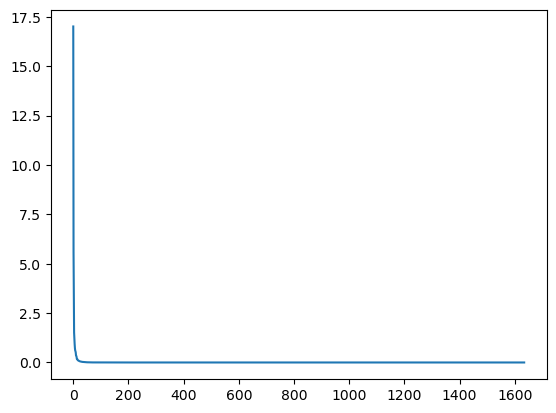

In [33]:
cov = np.cov(X_train[:,0,0,:].T)
eigvals, eigvecs = np.linalg.eig(cov)
plt.plot(np.abs(eigvals))
PR = (np.sum(eigvals)**2) / (np.sum(eigvals**2))
print('Participation ratio: ', np.abs(PR).round(3))

## PCA

In [34]:
dim = 3
pca = PCA(n_components=dim)
pca.fit(X_train[:,0,0,:])
print('Percentage of variance explained by the first ', dim, ' PCs: ', pca.explained_variance_ratio_[:dim].sum().round(3))

Percentage of variance explained by the first  3  PCs:  0.741


#### Projecting into latent space

In [35]:
Y0_tr = pca.transform(X_train[:,0,0,:])
Y1_tr = pca.transform(X_train[:,1,0,:])
Ydiff_tr = Y1_tr - Y0_tr

Y0_tst = pca.transform(X_test[:,0,0,:])
Y1_tst = pca.transform(X_test[:,1,0,:])
Ydiff_tst = Y1_tst - Y0_tst

np.savetxt('Saved_Y/Y0_tr__PCA_15past.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tr__PCA_15past.csv',Y1_tr)
np.savetxt('Saved_Y/Y0_tst__PCA_15past.csv',Y0_tst)
np.savetxt('Saved_Y/Y1_tst__PCA_15past.csv',Y1_tst)
np.savetxt('Saved_Y/B_train_1__PCA_15past.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__PCA_15past.csv',B_test_1)

#### Plotting first 3 PCs


(0.0, 2674.0, -0.5, 0.5)

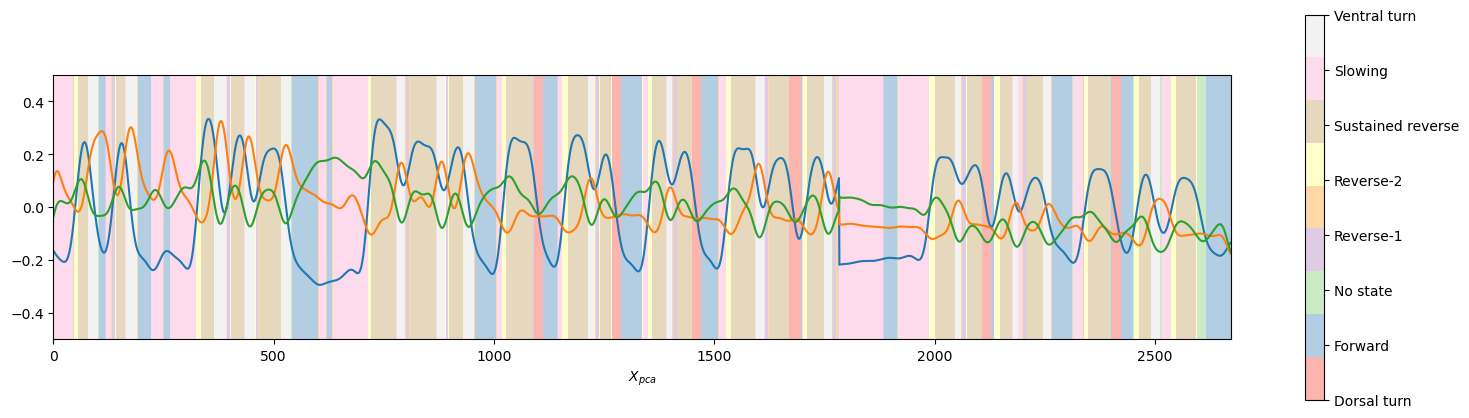

In [36]:
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_tr/Y0_tr.max()/3)
plt.xlabel("time $t$")
plt.xlabel("$X_{pca}$")
plt.axis([0,Y0_tr.shape[0],-0.5,0.5])


<IPython.core.display.Javascript object>


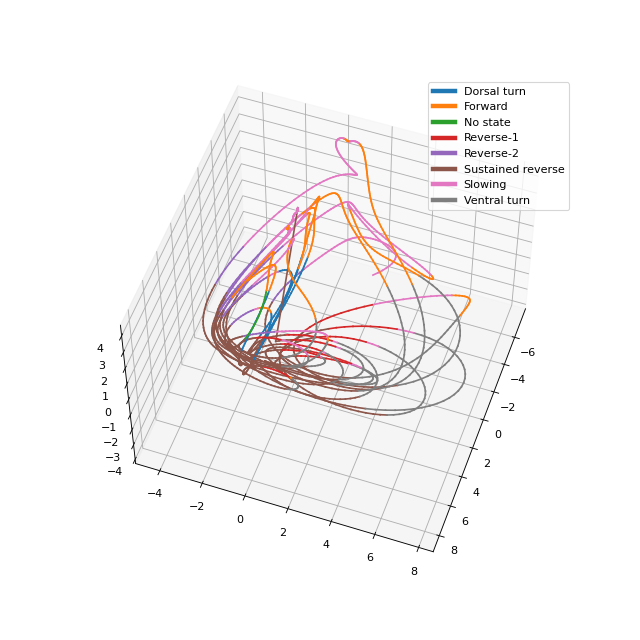

In [44]:
%matplotlib notebook
plot_phase_space(Y0_tr, B_train_1)

In [11]:
### Run to produce rotating 3-D plot
#%matplotlib notebook    
#rotating_plot(Y0_tr, B_train_1)

### Behaviour predictor


2022-09-07 18:15:51.646398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 18:15:51.646704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 18:15:51.646755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-07 18:15:51.646803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-07 18:15:51.646851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

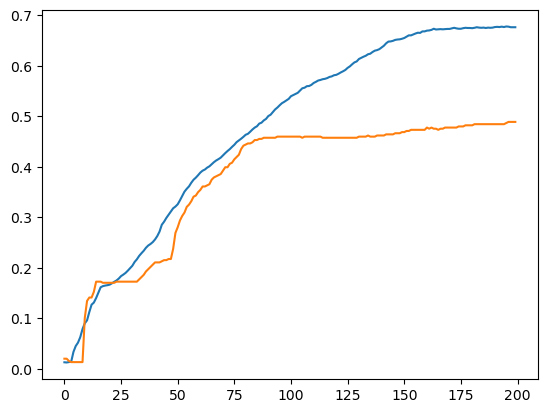

In [38]:
%matplotlib inline
b_predictor = tf.keras.Sequential([
#    layers.Dense(80, activation='relu'),
#    layers.Dense(20, activation='relu'),
    layers.Dense(8, activation='linear')
]) 
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

b_predictor.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = b_predictor.fit(Y1_tr,
                      B_train_1,
                      epochs=200,
                      batch_size=500,
                      validation_data=(Y1_tst, B_test_1),
                      verbose=0
                      )

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [39]:
B1_pred = b_predictor(Y1_tst).numpy().argmax(axis=1)
accuracy_score(B1_pred, B_test_1)

0.48878923766816146

### Autoregressor: Predicting $Y_{t+1}$ from $Y_t$

On training set 

Baseline mse 0.01573 Model mse: 0.01177

On test set 

Baseline mse 0.00763 Model mse: 0.00831
On training set 

Baseline mse 0.01573 Model mse: 0.0118

On test set 

Baseline mse 0.00763 Model mse: 0.00847
On training set 

Baseline mse 0.01573 Model mse: 0.01178

On test set 

Baseline mse 0.00763 Model mse: 0.00839
On training set 

Baseline mse 0.01573 Model mse: 0.01178

On test set 

Baseline mse 0.00763 Model mse: 0.00778
On training set 

Baseline mse 0.01573 Model mse: 0.01178

On test set 

Baseline mse 0.00763 Model mse: 0.00833
On training set 

Baseline mse 0.01573 Model mse: 0.01178

On test set 

Baseline mse 0.00763 Model mse: 0.00774
On training set 

Baseline mse 0.01573 Model mse: 0.01183

On test set 

Baseline mse 0.00763 Model mse: 0.0074
On training set 

Baseline mse 0.01573 Model mse: 0.01176

On test set 

Baseline mse 0.00763 Model mse: 0.008
On training set 

Baseline mse 0.01573 Model mse: 0.01179

On test set 

Baseline mse 0.00763 Model 

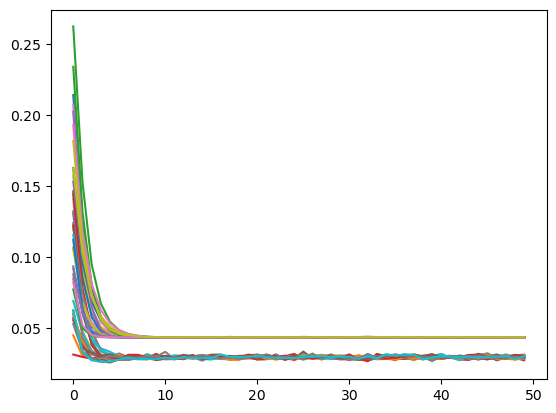

In [40]:
%matplotlib inline
mse_list = []
for i in range(20):
    ### Scaling input and output data
    Yinmax = (np.abs(Y0_tr)).max() # Parameters for scaling
    Y0_tr, Y0_tst = Y0_tr/Yinmax, Y0_tst/Yinmax
    Ydmax = (np.abs(Ydiff_tr)).max() # Parameters for scaling
    Ydiff_tr, Ydiff_tst = Ydiff_tr/Ydmax, Ydiff_tst/Ydmax

    # Defining the model
    model_ydiff_f_yt = tf.keras.Sequential([
        #tf.keras.layers.Dense(3, activation='relu'),
        #tf.keras.layers.Dense(5, activation='relu'),
        #tf.keras.layers.Dense(7, activation='relu'),
        #tf.keras.layers.Dense(10, activation='relu'),
        #tf.keras.layers.Dense(7, activation='relu'),
        #tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(3, activation='linear')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)

    model_ydiff_f_yt.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mse'])


    history = model_ydiff_f_yt.fit(Y0_tr,
                          Ydiff_tr,
                          epochs=50,
                          batch_size=100,
                          validation_data=(Y0_tst, Ydiff_tst),
                          verbose=0
                          )
    # Summarize history for accuracy
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])

    # Preidctions
    Ydiff_tr_pred = model_ydiff_f_yt(Y0_tr).numpy()
    Ydiff_tst_pred = model_ydiff_f_yt(Y0_tst).numpy()

    # Inverse scaling the data
    Ydiff_tr_pred, Ydiff_tr, Y0_tr = Ydiff_tr_pred*Ydmax, Ydiff_tr*Ydmax, Y0_tr*Yinmax
    Ydiff_tst_pred, Ydiff_tst, Y0_tst = Ydiff_tst_pred*Ydmax, Ydiff_tst*Ydmax, Y0_tst*Yinmax

    Y1_tr_pred = Y0_tr + Ydiff_tr_pred
    Y1_tst_pred = Y0_tst + Ydiff_tst_pred

    # Evaluation
    baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
    modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
    baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
    modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))
    
    print('On training set \n')
    print('Baseline mse', baseline_tr.round(5), 'Model mse:', modelmse_tr.round(5))
    print('\nOn test set \n')
    print('Baseline mse', baseline_tst.round(5), 'Model mse:', modelmse_tst.round(5))
    
    mse_list.append([baseline_tr, modelmse_tr, baseline_tst, modelmse_tst])

In [41]:
print(np.mean(mse_list, axis=0))
print(np.std(mse_list, axis=0))

[0.01573082 0.01177949 0.00763083 0.00802441]
[0.00000000e+00 1.51226474e-05 8.67361738e-19 2.82024186e-04]


#### Autoregression: with linear regression 
(deterministic as opposed to probabilistic neural net's solution)

In [42]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(Y0_tr, Ydiff_tr)

Ydiff_tr_pred = linear_reg.predict(Y0_tr)
Ydiff_tst_pred = linear_reg.predict(Y0_tst)

Y1_tr_pred = Y0_tr + Ydiff_tr_pred
Y1_tst_pred = Y0_tst + Ydiff_tst_pred

# Evaluation
baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))

print('On training set \n')
print('Baseline mse', baseline_tr.round(5), 'Model mse:', modelmse_tr.round(5))
print('\nOn test set \n')
print('Baseline mse', baseline_tst.round(5), 'Model mse:', modelmse_tst.round(5))

print('\nGoodness of autoregressor:', 1 - modelmse_tst/baseline_tst)

On training set 

Baseline mse 0.01573 Model mse: 0.01176

On test set 

Baseline mse 0.00763 Model mse: 0.00798

Goodness of autoregressor: -0.04635353492876071


In [43]:
hits_at_rank(5,Y1_tr, Y1_tr_pred)

0.8358264771877337